# Visualize Result of PHILHARMONIC Analysis

Lorem ipsum dolor...

In [26]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger
from matplotlib import pyplot as plt

from pathlib import Path

from philharmonic.utils import (
    load_cluster_json,
    parse_GO_database,
    parse_GO_map,
    plot_cluster,
    print_cluster,
    write_cluster_cytoscape,
)

In [30]:
# Initial Files
cluster_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_clusters.json"
network_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_network.positive.tsv"
go_map_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_GO_map.csv"

GO_DATABASE = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/go.obo"
IMG_DIR = Path("/mnt/home/ssledzieski/Projects/philharmonic-experiments/img/pdam")

# Initial Files
cluster_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/c_goreaui/20240926_philharmonic_v0.5.0_cgoreaui/20240926_cgoreaui_clusters.json"
network_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/c_goreaui/20240926_philharmonic_v0.5.0_cgoreaui/20240926_cgoreaui_network.positive.tsv"
go_map_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/c_goreaui/20240926_philharmonic_v0.5.0_cgoreaui/20240926_cgoreaui_GO_map.csv"

GO_DATABASE = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/c_goreaui/20240926_philharmonic_v0.5.0_cgoreaui/go.obo"
IMG_DIR = Path("/mnt/home/ssledzieski/Projects/philharmonic-experiments/img/cgor")

# # Initial Files
# cluster_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/d_melanogaster/20240913-dmelaAll-phil_v0.2.0/20240912-dmelaAll-phil_v0.2.0_clusters.json"
# network_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/d_melanogaster/20240913-dmelaAll-phil_v0.2.0/20240912-dmelaAll-phil_v0.2.0_network.positive.tsv"
# go_map_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/d_melanogaster/20240913-dmelaAll-phil_v0.2.0/20240912-dmelaAll-phil_v0.2.0_GO_map.csv"
# GO_DATABASE = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/d_melanogaster/20240913-dmelaAll-phil_v0.2.0/go.obo"
# IMG_DIR = Path("/mnt/home/ssledzieski/Projects/philharmonic-experiments/img/dmel")

In [31]:
clusters = load_cluster_json(cluster_file_path)
full_G = nx.read_weighted_edgelist(network_file_path)
go_map = parse_GO_map(go_map_path)
go_database = parse_GO_database(GO_DATABASE)

---

## Basic Network Statistics

In [32]:
label = ["Nodes", "Edges", "Degree (Med)", "Degree (Avg)", "Sparsity"]
degrees = [i[1] for i in list(full_G.degree())]
value = [
    len(full_G.nodes),
    len(full_G.edges),
    np.median(degrees),
    np.mean(degrees),
    len(full_G.edges()) / len(full_G) ** 2,
]
df = pd.DataFrame([label, value]).T
df.columns = ["", "Network"]
df = df.set_index("")
df

,Network
,
Nodes,8204
Edges,568536
Degree (Med),44.5
Degree (Avg),138.599707
Sparsity,0.008447


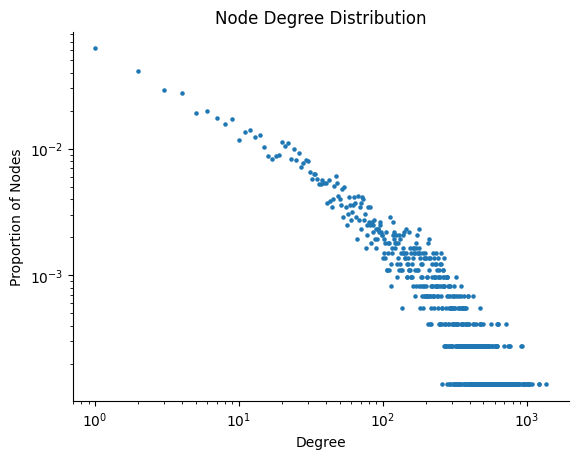

In [8]:
degreeDist = {}
for i in degrees:
    n = degreeDist.setdefault(i, 0)
    degreeDist[i] = n + 1

plt.scatter(degreeDist.keys(), [i / len(full_G) for i in degreeDist.values()], s=5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree")
plt.ylabel("Proportion of Nodes")
plt.title("Node Degree Distribution")
plt.savefig(IMG_DIR / "degree_distribution.svg", bbox_inches="tight", dpi=300)
sns.despine()

---

## Basic Cluster Statistics

In [9]:
logger.info(f"Number of clusters: {len(clusters)}")

2024-10-13 15:47:20.665 | INFO     | __main__:<module>:1 - Number of clusters: 468


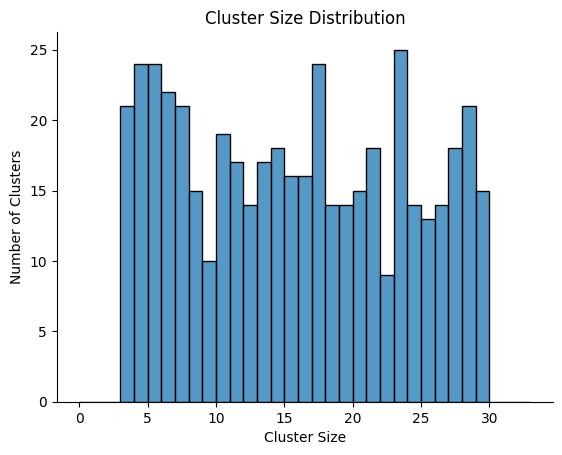

In [10]:
sizes = [len(i["members"]) for i in clusters.values()]
sns.histplot(sizes, bins=np.arange(0, max(sizes) + 5, max(sizes) // 20))
plt.xlabel("Cluster Size")
plt.ylabel("Number of Clusters")
plt.title("Cluster Size Distribution")
sns.despine()
plt.savefig(IMG_DIR / "size_distribution.svg", bbox_inches="tight", dpi=300)
plt.show()

---

## View Individual Clusters

In [24]:
i = 150
# k = list(clusters.keys())[i]
# k = "208641124039621440"
k = "1495076087230339862" # blue
# k = "1823305451748972384" # green
# k = "889733293002804025" # purple
# k = "363014559509114069" # red
# k = "1238085533603602511" # brown
# k = "803905878821692717" # orange
# k = "1468420370922021553"

In [25]:
print_cluster(clusters[k], go_database, 10)

Cluster of 15 proteins [pdam_00008678-RA, pdam_00021189-RA, pdam_00005806-RA, ...] (hash 1495076087230339862)
0 proteins re-added by ReCIPE (degree, 0.75)
Edges: 31
Triangles: 8
Max Degree: 8
Top Terms:
		GO:0071502 - <cellular response to temperature stimulus> (12)
		GO:0019233 - <sensory perception of pain> (12)
		GO:0002024 - <diet induced thermogenesis> (12)
		GO:0042391 - <regulation of membrane potential> (9)
		GO:0043547 - <positive regulation of GTPase activity> (8)
		GO:0070374 - <positive regulation of ERK1 and ERK2 cascade> (8)
		GO:0030168 - <platelet activation> (7)
		GO:0002032 - <obsolete desensitization of G protein-coupled receptor signaling pathway by arrestin> (7)
		GO:0022400 - <regulation of opsin-mediated signaling pathway> (7)
		GO:0051586 - <positive regulation of dopamine uptake involved in synaptic transmission> (7)



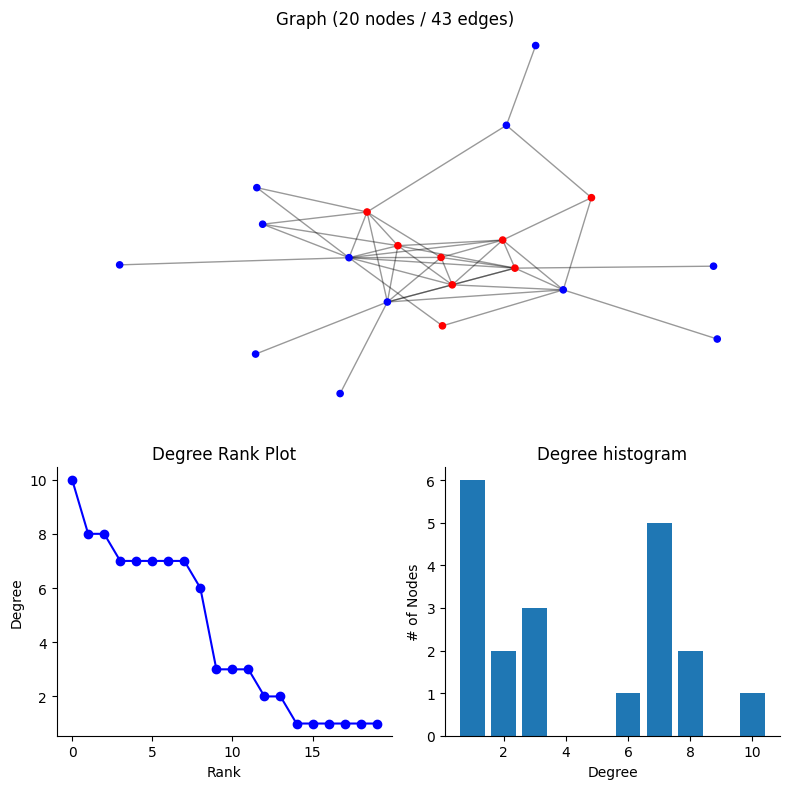

In [18]:
# plot_cluster(
#     clusters[k], full_G, use_recipe=True, savefig="../img/readme_sample_cluster.jpg"
# )
plot_cluster(
    clusters[k], full_G, use_recipe=True, savefig=None
)

In [19]:
write_cluster_cytoscape(clusters[k], full_G, f"{k}_cytoscape.txt")

In [21]:
for p in sorted(clusters[k]["members"] + list(clusters[k]["recipe"]["degree"]["0.75"])):
    # if "GO:0071502" in go_map[p/]:
    print(p)

pdam_00001381-RA
pdam_00001388-RA
pdam_00001389-RA
pdam_00001924-RA
pdam_00003290-RA
pdam_00003714-RA
pdam_00006109-RA
pdam_00006156-RA
pdam_00006320-RA
pdam_00006972-RA
pdam_00006973-RA
pdam_00008620-RA
pdam_00011550-RA
pdam_00011780-RA
pdam_00012376-RA
pdam_00012507-RA
pdam_00015999-RA
pdam_00018139-RA
pdam_00021982-RA
pdam_00024051-RA


## Overall ReCIPE Stats

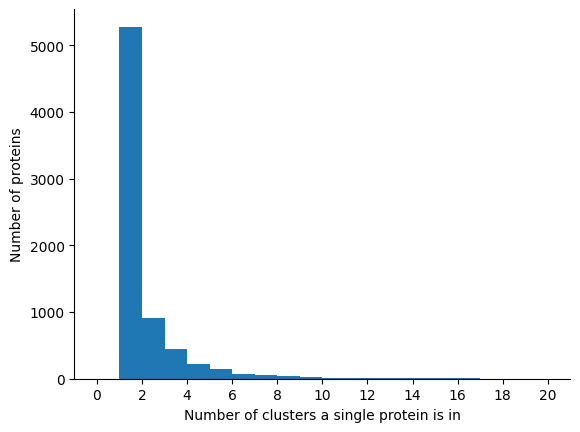

In [70]:
from collections import Counter
node_appearances = list()
for clust in clusters.values():
    for mn in clust["members"]:
        node_appearances.append(mn)
    for rn in clust["recipe"]["degree"]["0.75"]:
        node_appearances.append(rn)
nodes_counter = Counter(node_appearances)
plt.hist(nodes_counter.values(), bins=np.arange(0,21,1))
# xtick labels every 5
plt.xticks(np.arange(0, 21, 2))
plt.xlabel("Number of clusters a single protein is in")
plt.ylabel("Number of proteins")
sns.despine()
plt.savefig(IMG_DIR / "protein_number_of_clusters.png", bbox_inches="tight", dpi=300)
plt.show()